In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import tensorflow as tf
import numpy as np
import gym
from tqdm import tqdm, trange
import os,sys
sys.path.append(os.getcwd())

Populating the interactive namespace from numpy and matplotlib


In [2]:
from muzero.model import MuModel

In [3]:
env = gym.make("CartPole-v0")
m = MuModel(env.observation_space.shape, env.action_space.n)
env.reset(), env.observation_space.shape, env.action_space.n

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


(array([-0.00716157, -0.04714213, -0.03845419, -0.03546812]), (4,), 2)

In [4]:
from muzero.game import Game, ReplayBuffer
replay_buffer = ReplayBuffer(100, 128)

In [5]:
def to_one_hot(x,n):
  ret = np.zeros([n])
  ret[x] = 1.0
  return ret

# enumerate the whole action space
K = 5
import itertools
aopts = list(itertools.product([0,1], repeat=K))
aoptss = np.array([[to_one_hot(x, env.action_space.n) for x in aa] for aa in aopts])
aoptss = aoptss.swapaxes(0,1)
aoptss = [aoptss[x] for x in range(K)]

# TODO: this is naive search, replace with MCTS
def search(m, o_0, debug=False):
  # concatenate the current state with every possible action
  o_0s = np.repeat(np.array(o_0)[None], len(aopts), axis=0)
  ret = m.mu.predict([o_0s]+aoptss)
  v_s = ret[-3]
  
  # group the value with the action rollout that caused it
  v = [(v_s[i][0], aopts[i]) for i in range(len(v_s))]
  if debug:
    print(sorted(v, reverse=True))
  
  av = [0] * env.action_space.n
  for vk, ak in v:
    av[ak[0]] += vk
    
  policy = np.exp(av)/sum(np.exp(av))
  return policy

In [6]:
def play_game():
  import random
  game = Game(env)
  while not game.terminal():
    policy = search(m, game.observation)
    act = np.random.choice(list(range(len(policy))), p=policy)
    game.apply(act)
  return game

In [7]:
from muzero.model import reformat_batch
for j in range(50):
  game = play_game()
  replay_buffer.save_game(game)
  for i in range(10):
    m.train_on_batch(replay_buffer.sample_batch(5))
  print(len(game.history), m.losses[-1][0])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
33 705.0277
13 327.77908
13 230.03664
12 148.66544
23 142.1553
19 140.42955
16 122.265236
16 97.97898
43 134.67424
12 123.585396
29 132.12921
9 115.78555
8 79.65004
62 99.84648
11 111.1576
29 115.22566
73 118.31672
92 123.898415
103 99.22566
155 100.18333
79 125.92854
85 123.38021
106 123.84061
96 107.30619
61 110.26352
160 101.88205
200 107.16171
200 101.06904
200 95.47177
200 89.413445
200 98.198654
200 97.598724
200 82.94844
200 75.68001


KeyboardInterrupt: 

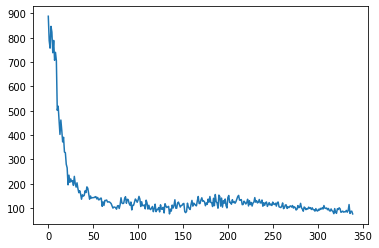

In [8]:
plot([x[0] for x in m.losses])

In [11]:
# can act?
state = env.reset()
for sn in range(2000):
  p_0 = search(m, state, debug=False)
  a_1 = np.random.choice(list(range(len(p_0))), p=p_0)
  #a_1 = np.argmax(p_0)
  #print(p_0, v_0, a_1)
  env.render()
  state,r,done,_ = env.step(a_1)
  if done:
    print("DONE", sn)
    break

DONE 199
